# Rianna's ML models

In [25]:
# import data
import pickle
with open("rianna_data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## ML Models

### Method: XGBoost

In [27]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#### Plotting function

In [28]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.savefig("XGB Regressor Train and Validation RMSE Scores")

In [29]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

#### Hyperparameter tuning  and regularization with RandomizedSearchCV

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'learning_rate': uniform(0.001, 0.2),
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 400),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [1, 5, 10] # L2 regularization
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best hyperparameters found:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.662397808134481), 'learning_rate': np.float64(0.012616722433639892), 'max_depth': 7, 'n_estimators': 149, 'reg_alpha': 0.5, 'reg_lambda': 5, 'subsample': np.float64(0.6225646316108401)}


#### K-Fold Cross-Validation

Fold 1 — Train MSE: 0.9871
Fold 2 — Train MSE: 0.9741
Fold 3 — Train MSE: 0.9909
Fold 4 — Train MSE: 0.9808
Fold 5 — Train MSE: 0.9796
Average Train MSE: 0.9825 ± 0.0059


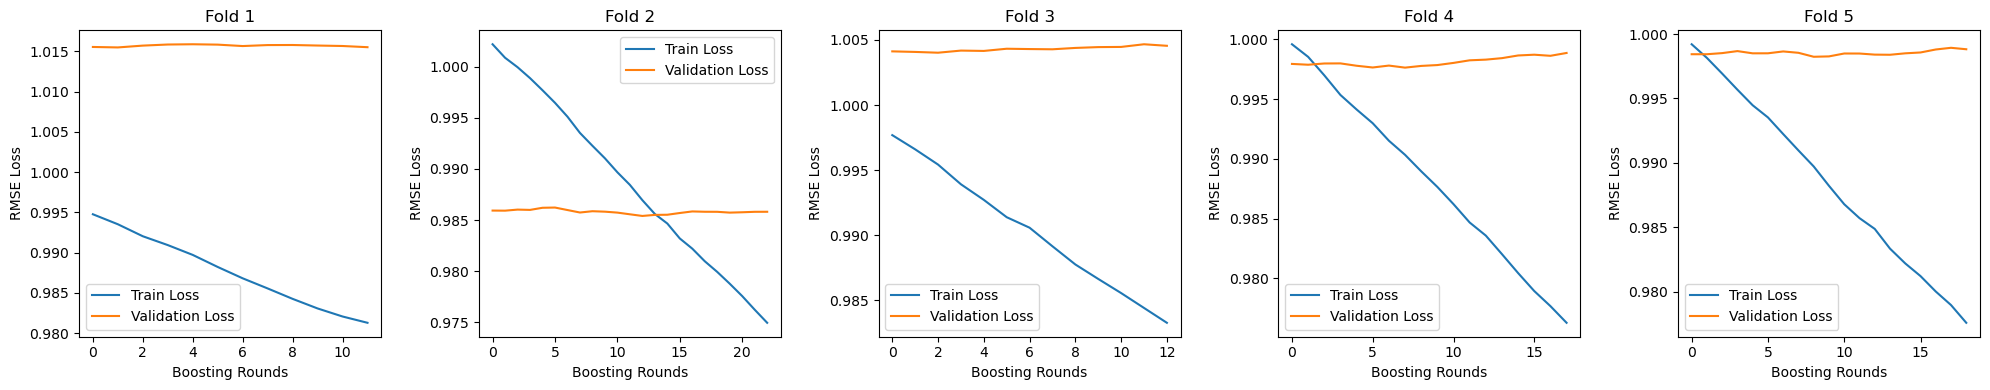

In [32]:
# 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_mse_scores = []
eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # X_train_in, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    # y_train_in, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    X_train_in, X_val = X_train[train_idx], X_train[val_idx] 
    y_train_in, y_val = y_train[train_idx], y_train[val_idx]

    xgb_model = XGBRegressor(
        **best_params,
        random_state=42,
        eval_metric="rmse",
        early_stopping_rounds=10,
        n_jobs=-1
    )

    xgb_model.fit(
        X_train_in,
        y_train_in,
        eval_set= [(X_train_in, y_train_in), (X_val, y_val)], #[(X_val, y_val)],
        verbose=False,
    )

    evals_result = xgb_model.evals_result()
    eval_scores.append(evals_result)

    y_train_pred = xgb_model.predict(X_train_in)
    train_mse = mean_squared_error(y_train_in, y_train_pred)
    train_mse_scores.append(train_mse)

    print(f"Fold {fold + 1} — Train MSE: {train_mse:.4f}")
    
plot_train_val_losses(eval_scores)

print(f"Average Train MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")

#### Test Results

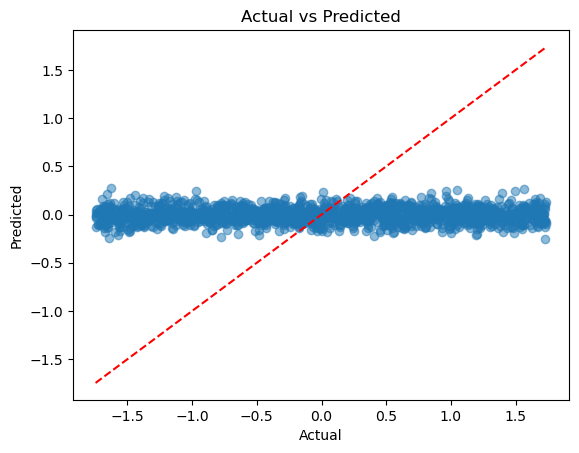

1.010652729797881
Final Test MSE: 1.0135
Final Test R²: -0.0028


In [33]:
# remake new model on best params
xgb_model = XGBRegressor(
    **best_params,
    random_state=42,
    eval_metric="rmse",
    n_jobs=-1
)
# xgb_model.early_stopping_rounds = None
xgb_model.fit(X_train, y_train) # Re-fit on all training data
y_test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

plot_actual_vs_predicted(y_test, y_test_pred)
print(np.var(y_test))

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

[0.00717496 0.00732746 0.00940228 0.01214666 0.01142235 0.01139524
 0.01329487 0.01367967 0.0127793  0.01448204 0.01857445 0.0151714
 0.01455695 0.01683517 0.01821576 0.01546424 0.01693948 0.0157505
 0.0162052  0.01642352 0.01620887 0.01760373 0.01664321 0.01631963
 0.01692178 0.01807463 0.02065173 0.01934478 0.01943038 0.01805726
 0.01794918 0.01873781 0.01845506 0.01653118 0.01911493 0.01665547
 0.01919563 0.01686669 0.01956097 0.01820796 0.01775819 0.01778567
 0.0201276  0.01871874 0.01869555 0.01565387 0.01795531 0.01689318
 0.01655324 0.01768665 0.02048641 0.01856946 0.01738705 0.01742308
 0.01784028 0.01751314 0.01862992 0.02031893 0.01852678 0.01770458]


<Figure size 800x1200 with 0 Axes>

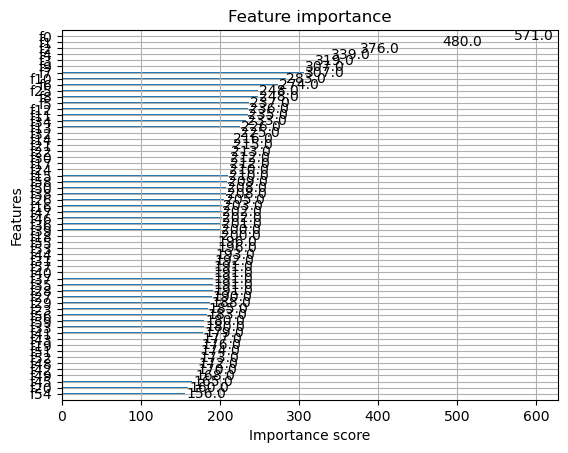

In [34]:
feat_imps = xgb_model.feature_importances_
print(feat_imps)
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model)
plt.show()

### Production mode

### Final Results